# üå± Analyse Saisonni√®re des Ratings d'Ingr√©dients

## Objectif
Analyser les variations saisonni√®res dans l'appr√©ciation des ingr√©dients pour identifier :
- Les ingr√©dients avec des pr√©f√©rences saisonni√®res marqu√©es
- Les patterns de consommation selon les saisons
- Les opportunit√©s de menu saisonnier

## M√©thodologie
- **Test statistique** : ANOVA pour comparer les moyennes entre saisons
- **Post-hoc** : Test de Tukey pour identifier les diff√©rences par paires
- **Agr√©gation** : Ratings moyens par saison et ingr√©dient
- **Visualisation** : Box plots et radar charts saisonniers
- **Seuil de significativit√©** : p < 0.05

## D√©finition des Saisons
- **Printemps** : Mars, Avril, Mai
- **√ât√©** : Juin, Juillet, Ao√ªt  
- **Automne** : Septembre, Octobre, Novembre
- **Hiver** : D√©cembre, Janvier, F√©vrier

In [ ]:
# Import des biblioth√®ques n√©cessaires
import sys
sys.path.append('..')

# üéØ Chargement des fonctions utilitaires depuis le fichier Python (plus robuste)
from _data_utils import *

import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from scipy import stats
from scipy.stats import f_oneway, tukey_hsd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Couleurs pour les saisons
SEASON_COLORS = {
    'Printemps': '#90EE90',  # Vert clair
    '√ât√©': '#FFD700',        # Jaune dor√©
    'Automne': '#FF8C00',    # Orange
    'Hiver': '#87CEEB'       # Bleu ciel
}

print("üìö Toutes les biblioth√®ques import√©es avec succ√®s !")
print("üå± Analyse saisonni√®re pr√™te √† d√©marrer !")

üìö Toutes les biblioth√®ques import√©es avec succ√®s !
üå± Analyse saisonni√®re pr√™te √† d√©marrer !


In [4]:
# Fonction pour mapper les mois aux saisons
def get_season(month):
    """
    Convertit un num√©ro de mois en saison
    """
    if month in [3, 4, 5]:
        return 'Printemps'
    elif month in [6, 7, 8]:
        return '√ât√©'
    elif month in [9, 10, 11]:
        return 'Automne'
    else:  # [12, 1, 2]
        return 'Hiver'

print('‚úÖ Fonction de mapping saisons d√©finie')

‚úÖ Fonction de mapping saisons d√©finie


In [5]:
# Chargement des donn√©es pour analyse saisonni√®re
print('üîÑ Chargement des donn√©es...')

# Ingr√©dients cibles pour l'analyse saisonni√®re (pr√©sents dans les 4 saisons)
target_ingredients = get_ingredients_for_analysis('seasonality')
print(f'üìã Ingr√©dients s√©lectionn√©s: {target_ingredients}')

# Chargement du dataset
df = load_ingredient_ratings(target_ingredients)
print(f'‚úÖ Dataset charg√©: {df.shape[0]:,} interactions')
print(f'üìÖ P√©riode: {df["date"].min()} ‚Üí {df["date"].max()}')

# Ajout de la colonne saison
df = df.with_columns([
    pl.col('date').dt.month().alias('month')
]).with_columns([
    pl.col('month').map_elements(get_season, return_dtype=pl.Utf8).alias('season')
])

print('\nüìä Distribution par saison:')
season_dist = df.group_by('season').agg(pl.len().alias('count')).sort('count', descending=True)
print(season_dist)

print('\nüìä Aper√ßu des donn√©es avec saisons:')
print(df.select(['date', 'month', 'season', 'ingredient_name', 'rating']).head())

üîÑ Chargement des donn√©es...
üìã Ingr√©dients s√©lectionn√©s: ['salt', 'ground beef', 'eggs', 'onions', 'garlic', 'butternut squash', 'asparagus', 'pumpkin']
‚úÖ Donn√©es charg√©es: 845,309 interactions pour 8 ingr√©dients
‚úÖ Dataset charg√©: 845,309 interactions
üìÖ P√©riode: 2000-01-25 ‚Üí 2018-12-20

üìä Distribution par saison:
shape: (4, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ season    ‚îÜ count  ‚îÇ
‚îÇ ---       ‚îÜ ---    ‚îÇ
‚îÇ str       ‚îÜ u32    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Hiver     ‚îÜ 224373 ‚îÇ
‚îÇ Automne   ‚îÜ 213140 ‚îÇ
‚îÇ Printemps ‚îÜ 209557 ‚îÇ
‚îÇ √ât√©       ‚îÜ 198239 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

üìä Aper√ßu des donn√©es avec saisons:
shape: (5, 5)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê


In [6]:
# Agr√©gation des donn√©es par saison et ingr√©dient
print('üîß Agr√©gation des donn√©es saisonni√®res...')

df_seasonal = df.group_by(['ingredient_name', 'season']).agg([
    pl.col('rating').mean().alias('avg_rating'),
    pl.col('rating').count().alias('n_ratings'),
    pl.col('rating').std().alias('std_rating'),
    pl.col('rating').median().alias('median_rating')
]).sort(['ingredient_name', 'season'])

print(f'‚úÖ Donn√©es agr√©g√©es: {df_seasonal.shape[0]} points saison-ingr√©dient')

# V√©rification de la couverture saisonni√®re par ingr√©dient
season_coverage = df_seasonal.group_by('ingredient_name').agg([
    pl.col('season').n_unique().alias('seasons_covered'),
    pl.col('n_ratings').sum().alias('total_ratings')
]).sort('total_ratings', descending=True)

print('\nüìà Couverture saisonni√®re par ingr√©dient:')
print(season_coverage)

# Filtrer les ingr√©dients avec couverture compl√®te (4 saisons)
complete_ingredients = season_coverage.filter(
    pl.col('seasons_covered') == 4
)['ingredient_name'].to_list()

print(f'\nüéØ Ingr√©dients avec couverture compl√®te (4 saisons): {len(complete_ingredients)}')
print(f'Ingr√©dients: {complete_ingredients}')

üîß Agr√©gation des donn√©es saisonni√®res...
‚úÖ Donn√©es agr√©g√©es: 32 points saison-ingr√©dient

üìà Couverture saisonni√®re par ingr√©dient:
shape: (8, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ ingredient_name  ‚îÜ seasons_covered ‚îÜ total_ratings ‚îÇ
‚îÇ ---              ‚îÜ ---             ‚îÜ ---           ‚îÇ
‚îÇ str              ‚îÜ u32             ‚îÜ u32           ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ salt             ‚îÜ 4               ‚îÜ 468403        ‚îÇ
‚îÇ eggs             ‚îÜ 4               ‚îÜ 178000        ‚îÇ
‚îÇ garlic           ‚îÜ 4               ‚îÜ 102506        ‚îÇ
‚îÇ onions           ‚îÜ 4               ‚îÜ 48041         ‚îÇ
‚îÇ ground beef      ‚îÜ 4               ‚îÜ 37195         ‚îÇ
‚îÇ pump

In [8]:
# Test ANOVA pour d√©tecter les diff√©rences saisonni√®res
print('üîç Test ANOVA pour les diff√©rences saisonni√®res...')

anova_results = []

for ingredient in complete_ingredients:
    # Donn√©es pour cet ingr√©dient par saison
    ingredient_data = df.filter(pl.col('ingredient_name') == ingredient)
    
    # Extraction des ratings par saison
    spring_ratings = ingredient_data.filter(pl.col('season') == 'Printemps')['rating'].to_list()
    summer_ratings = ingredient_data.filter(pl.col('season') == '√ât√©')['rating'].to_list()
    autumn_ratings = ingredient_data.filter(pl.col('season') == 'Automne')['rating'].to_list()
    winter_ratings = ingredient_data.filter(pl.col('season') == 'Hiver')['rating'].to_list()
    
    # Test ANOVA
    if all(len(ratings) > 0 for ratings in [spring_ratings, summer_ratings, autumn_ratings, winter_ratings]):
        f_stat, p_value = f_oneway(spring_ratings, summer_ratings, autumn_ratings, winter_ratings)
        
        # Calcul des moyennes par saison
        season_means = {
            'spring_mean': np.mean(spring_ratings),
            'summer_mean': np.mean(summer_ratings),
            'autumn_mean': np.mean(autumn_ratings),
            'winter_mean': np.mean(winter_ratings)
        }
        
        # Identification de la meilleure et pire saison
        best_season = max(season_means, key=season_means.get).replace('_mean', '')
        worst_season = min(season_means, key=season_means.get).replace('_mean', '')
        
        anova_results.append({
            'ingredient': ingredient,
            'f_statistic': f_stat,
            'p_value': p_value,
            'significant': p_value < 0.05,  # Bool√©en pur
            'spring_avg': season_means['spring_mean'],
            'summer_avg': season_means['summer_mean'],
            'autumn_avg': season_means['autumn_mean'],
            'winter_avg': season_means['winter_mean'],
            'best_season': best_season.title(),
            'worst_season': worst_season.title(),
            'seasonal_range': max(season_means.values()) - min(season_means.values())
        })

# Conversion en DataFrame Polars
anova_df = pl.DataFrame(anova_results).sort('p_value')

print('\nüìä R√©sultats ANOVA pour les diff√©rences saisonni√®res:')
print(anova_df.select(['ingredient', 'f_statistic', 'p_value', 'significant', 'best_season', 'seasonal_range']))

# R√©sum√© des diff√©rences significatives
significant_seasonal = anova_df.filter(pl.col('significant') == True)
print(f'\nüéØ Ingr√©dients avec variations saisonni√®res significatives: {len(significant_seasonal)}/{len(complete_ingredients)}')

if len(significant_seasonal) > 0:
    print('\nVariations saisonni√®res significatives:')
    for row in significant_seasonal.iter_rows(named=True):
        print(f"üå± {row['ingredient']}: Meilleure saison = {row['best_season']} " +
              f"(amplitude = {row['seasonal_range']:.4f}, p={row['p_value']:.4f})")
else:
    print('‚û°Ô∏è Aucune variation saisonni√®re significative d√©tect√©e')

üîç Test ANOVA pour les diff√©rences saisonni√®res...

üìä R√©sultats ANOVA pour les diff√©rences saisonni√®res:
shape: (8, 6)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ ingredient       ‚îÜ f_statistic ‚îÜ p_value    ‚îÜ significant ‚îÜ best_season ‚îÜ seasonal_range ‚îÇ
‚îÇ ---              ‚îÜ ---         ‚îÜ ---        ‚îÜ ---         ‚îÜ ---         ‚îÜ ---            ‚îÇ
‚îÇ str              ‚îÜ f64         ‚îÜ f64        ‚îÜ f64         ‚îÜ str         ‚îÜ f64            ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê

In [9]:
# Analyse d√©taill√©e par paires pour les ingr√©dients significatifs
print('üîç Tests par paires (Mann-Whitney U) pour les diff√©rences saisonni√®res...')

from scipy.stats import mannwhitneyu

tukey_results = {}

for ingredient in significant_seasonal['ingredient'].to_list():
    print(f'\nüìä Analyse d√©taill√©e pour {ingredient}:')
    
    # Pr√©paration des donn√©es par saison
    ingredient_data = df.filter(pl.col('ingredient_name') == ingredient)
    
    seasons = ['Printemps', '√ât√©', 'Automne', 'Hiver']
    season_data = {}
    
    for season in seasons:
        season_ratings = ingredient_data.filter(pl.col('season') == season)['rating'].to_list()
        season_data[season] = season_ratings
        print(f"   {season}: {len(season_ratings)} ratings, moyenne = {np.mean(season_ratings):.4f}")
    
    # Test par paires avec Mann-Whitney U
    print(f'\n   üîç Comparaisons par paires significatives (p<0.05):')
    significant_pairs = []
    
    for i, season1 in enumerate(seasons):
        for j, season2 in enumerate(seasons[i+1:], i+1):
            try:
                u_stat, p_value = mannwhitneyu(season_data[season1], season_data[season2], alternative='two-sided')
                if p_value < 0.05:
                    mean_diff = np.mean(season_data[season1]) - np.mean(season_data[season2])
                    direction = '>' if mean_diff > 0 else '<'
                    significant_pairs.append(f"   ‚Üí {season1} {direction} {season2}: Œî={mean_diff:+.4f} (p={p_value:.4f})")
            except Exception as e:
                continue
    
    if significant_pairs:
        for pair in significant_pairs:
            print(pair)
    else:
        print('   ‚Üí Aucune diff√©rence par paires significative d√©tect√©e')
    
    tukey_results[ingredient] = significant_pairs

print(f'\n‚úÖ Tests par paires termin√©s pour {len(tukey_results)} ingr√©dients')

üîç Tests par paires (Mann-Whitney U) pour les diff√©rences saisonni√®res...

üìä Analyse d√©taill√©e pour salt:
   Printemps: 115611 ratings, moyenne = 4.3938
   √ât√©: 112107 ratings, moyenne = 4.4103
   Automne: 116457 ratings, moyenne = 4.3828
   Hiver: 124228 ratings, moyenne = 4.3701

   üîç Comparaisons par paires significatives (p<0.05):
   ‚Üí Printemps < √ât√©: Œî=-0.0165 (p=0.0001)
   ‚Üí Printemps > Automne: Œî=+0.0110 (p=0.0450)
   ‚Üí Printemps > Hiver: Œî=+0.0237 (p=0.0134)
   ‚Üí √ât√© > Automne: Œî=+0.0275 (p=0.0000)
   ‚Üí √ât√© > Hiver: Œî=+0.0402 (p=0.0000)

üìä Analyse d√©taill√©e pour eggs:
   Printemps: 44683 ratings, moyenne = 4.3581
   √ât√©: 39859 ratings, moyenne = 4.3718
   Automne: 45231 ratings, moyenne = 4.3495
   Hiver: 48227 ratings, moyenne = 4.3365

   üîç Comparaisons par paires significatives (p<0.05):
   ‚Üí Printemps > Hiver: Œî=+0.0216 (p=0.0058)
   ‚Üí √ât√© > Automne: Œî=+0.0222 (p=0.0078)
   ‚Üí √ât√© > Hiver: Œî=+0.0353 (p=0.0003)

üìä 

üìä Cr√©ation des visualisations saisonni√®res...


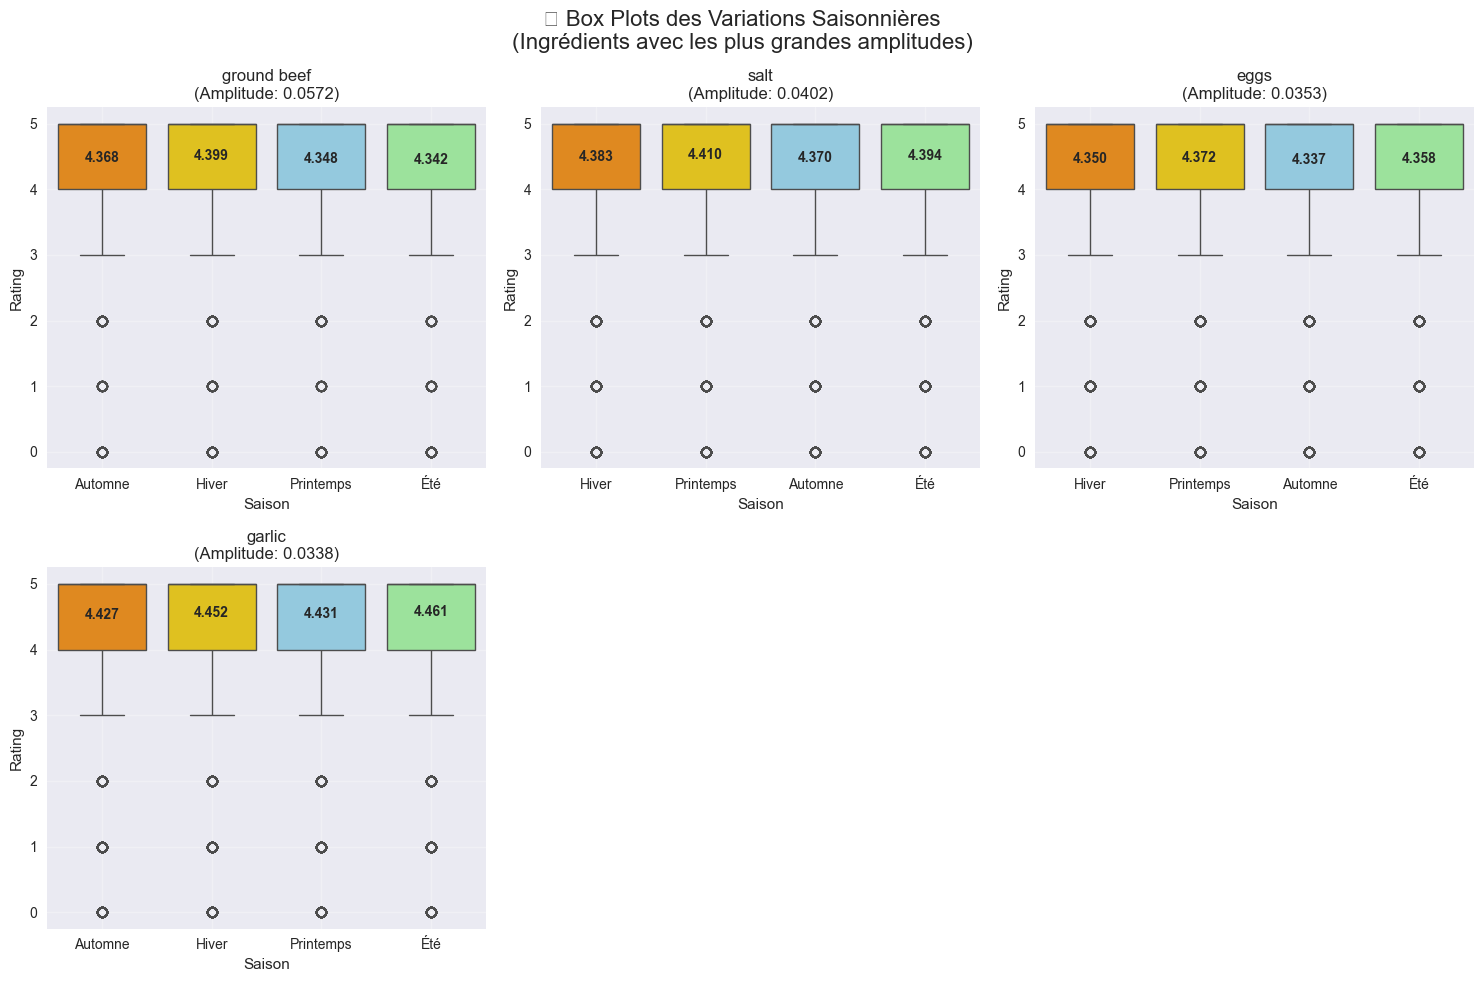

‚úÖ Box plots saisonniers cr√©√©s


In [10]:
# Visualisation 1: Box plots saisonniers
print('üìä Cr√©ation des visualisations saisonni√®res...')

# S√©lection des ingr√©dients les plus int√©ressants (avec variations significatives)
top_seasonal_ingredients = significant_seasonal.sort('seasonal_range', descending=True).head(6)['ingredient'].to_list()

if len(top_seasonal_ingredients) > 0:
    # Cr√©ation des subplots
    n_ingredients = len(top_seasonal_ingredients)
    n_cols = 3
    n_rows = (n_ingredients + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, ingredient in enumerate(top_seasonal_ingredients):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]
        
        # Donn√©es pour cet ingr√©dient
        ingredient_data = df.filter(pl.col('ingredient_name') == ingredient)
        
        # Conversion en pandas pour seaborn
        plot_data = ingredient_data.select(['season', 'rating']).to_pandas()
        
        # Box plot avec couleurs saisonni√®res
        sns.boxplot(data=plot_data, x='season', y='rating', ax=ax,
                   palette=[SEASON_COLORS[season] for season in ['Automne', '√ât√©', 'Hiver', 'Printemps']])
        
        # Ajout des moyennes
        season_means = plot_data.groupby('season')['rating'].mean()
        for j, season in enumerate(['Automne', '√ât√©', 'Hiver', 'Printemps']):
            if season in season_means.index:
                ax.text(j, season_means[season], f'{season_means[season]:.3f}', 
                       ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        ax.set_title(f'{ingredient}\n(Amplitude: {significant_seasonal.filter(pl.col("ingredient") == ingredient)["seasonal_range"].item():.4f})')
        ax.set_xlabel('Saison')
        ax.set_ylabel('Rating')
        ax.grid(True, alpha=0.3)
    
    # Masquer les axes vides
    for i in range(len(top_seasonal_ingredients), n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].set_visible(False)
    
    plt.suptitle('üå± Box Plots des Variations Saisonni√®res\n(Ingr√©dients avec les plus grandes amplitudes)', 
                fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    print('‚úÖ Box plots saisonniers cr√©√©s')
else:
    print('‚ö†Ô∏è  Aucune variation saisonni√®re significative d√©tect√©e')

üï∑Ô∏è Cr√©ation du radar chart saisonnier...


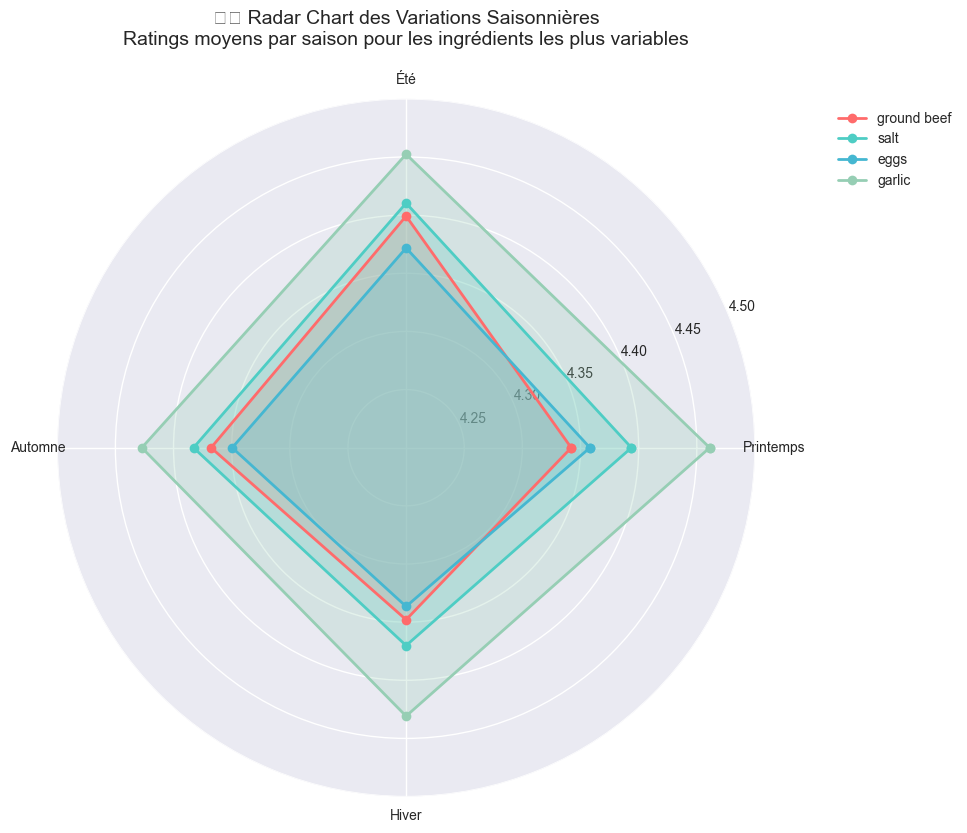

‚úÖ Radar chart saisonnier cr√©√©


In [12]:
# Visualisation 2: Radar chart saisonnier avec matplotlib
if len(significant_seasonal) > 0:
    print('üï∑Ô∏è Cr√©ation du radar chart saisonnier...')
    
    # S√©lection des 4 ingr√©dients les plus variables
    radar_ingredients = significant_seasonal.sort('seasonal_range', descending=True).head(4)['ingredient'].to_list()
    
    # Configuration du radar chart
    import math
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    seasons_order = ['Printemps', '√ât√©', 'Automne', 'Hiver']
    angles = [n / float(len(seasons_order)) * 2 * math.pi for n in range(len(seasons_order))]
    angles += angles[:1]  # Fermer le polygone
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    
    for i, ingredient in enumerate(radar_ingredients):
        # R√©cup√©ration des moyennes saisonni√®res
        ingredient_row = anova_df.filter(pl.col('ingredient') == ingredient).row(0, named=True)
        
        values = [
            ingredient_row['spring_avg'],
            ingredient_row['summer_avg'],
            ingredient_row['autumn_avg'],
            ingredient_row['winter_avg']
        ]
        values += values[:1]  # Fermer le polygone
        
        ax.plot(angles, values, 'o-', linewidth=2, label=ingredient, color=colors[i])
        ax.fill(angles, values, alpha=0.25, color=colors[i])
    
    # Configuration des axes
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(seasons_order)
    ax.set_ylim(4.2, 4.5)  # Ajuster selon les donn√©es
    ax.set_title('üï∑Ô∏è Radar Chart des Variations Saisonni√®res\nRatings moyens par saison pour les ingr√©dients les plus variables', 
                 size=14, pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    print('‚úÖ Radar chart saisonnier cr√©√©')
else:
    print('‚ö†Ô∏è  Pas assez de donn√©es pour le radar chart')

üî• Cr√©ation de la heatmap saisonni√®re...


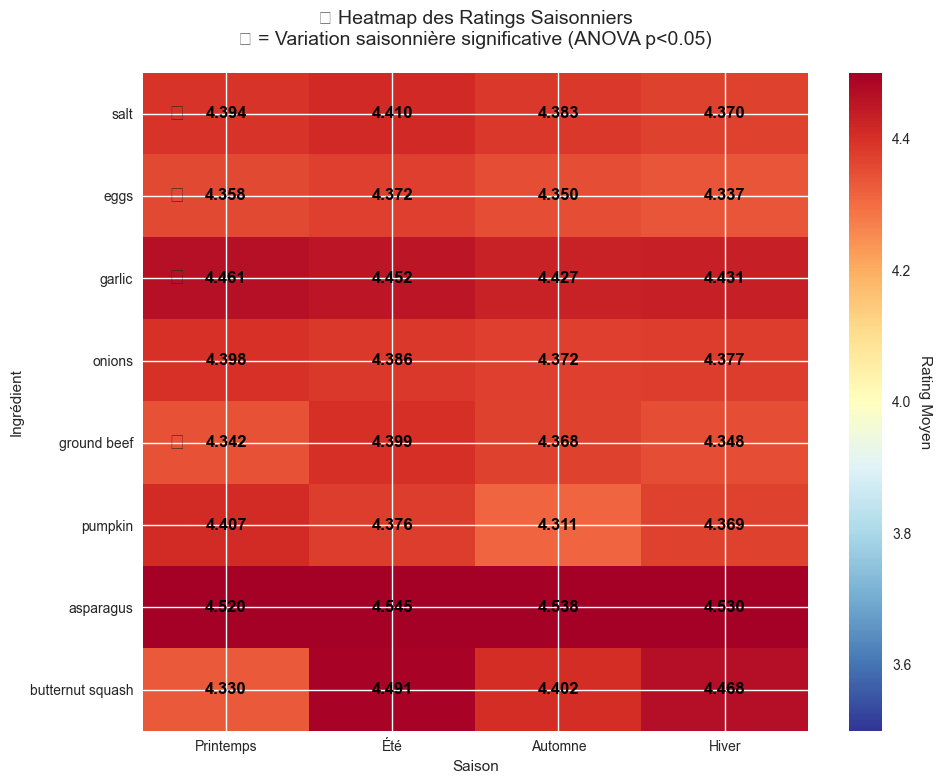

‚úÖ Heatmap saisonni√®re cr√©√©e


In [13]:
# Visualisation 3: Heatmap des moyennes saisonni√®res
print('üî• Cr√©ation de la heatmap saisonni√®re...')

# Pr√©paration de la matrice des moyennes
heatmap_data = []
heatmap_ingredients = []

for ingredient in complete_ingredients:
    ingredient_row = anova_df.filter(pl.col('ingredient') == ingredient)
    if len(ingredient_row) > 0:
        row_data = ingredient_row.row(0, named=True)
        heatmap_data.append([
            row_data['spring_avg'],
            row_data['summer_avg'],
            row_data['autumn_avg'],
            row_data['winter_avg']
        ])
        heatmap_ingredients.append(ingredient)

# Cr√©ation de la heatmap
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(heatmap_data, cmap='RdYlBu_r', aspect='auto', vmin=3.5, vmax=4.5)

# Configuration des axes
seasons = ['Printemps', '√ât√©', 'Automne', 'Hiver']
ax.set_xticks(range(len(seasons)))
ax.set_xticklabels(seasons)
ax.set_yticks(range(len(heatmap_ingredients)))
ax.set_yticklabels(heatmap_ingredients)

# Ajout des valeurs dans les cellules
for i in range(len(heatmap_ingredients)):
    for j in range(len(seasons)):
        value = heatmap_data[i][j]
        # Couleur du texte selon l'intensit√©
        text_color = 'white' if value < 4.0 else 'black'
        text = ax.text(j, i, f'{value:.3f}',
                      ha="center", va="center", color=text_color, fontweight='bold')

# Ajout d'√©toiles pour les variations significatives
for i, ingredient in enumerate(heatmap_ingredients):
    if ingredient in significant_seasonal['ingredient'].to_list():
        ax.text(-0.3, i, '‚≠ê', ha="center", va="center", fontsize=16)

# Colorbar et titre
cbar = plt.colorbar(im)
cbar.set_label('Rating Moyen', rotation=270, labelpad=15)

plt.title('üî• Heatmap des Ratings Saisonniers\n‚≠ê = Variation saisonni√®re significative (ANOVA p<0.05)', 
         fontsize=14, pad=20)
plt.xlabel('Saison')
plt.ylabel('Ingr√©dient')
plt.tight_layout()
plt.show()

print('‚úÖ Heatmap saisonni√®re cr√©√©e')

In [14]:
# Analyse des patterns saisonniers
print('üîç Analyse des patterns saisonniers...')

if len(significant_seasonal) > 0:
    # Groupement par saison pr√©f√©r√©e
    seasonal_preferences = significant_seasonal.group_by('best_season').agg([
        pl.col('ingredient').count().alias('n_ingredients'),
        pl.col('ingredient').alias('ingredients_list')
    ]).sort('n_ingredients', descending=True)
    
    print('üå± R√©partition des pr√©f√©rences saisonni√®res:')
    for row in seasonal_preferences.iter_rows(named=True):
        season_emoji = {'Printemps': 'üå±', '√ât√©': '‚òÄÔ∏è', 'Automne': 'üçÇ', 'Hiver': '‚ùÑÔ∏è'}
        emoji = season_emoji.get(row['best_season'], 'üåø')
        print(f"{emoji} {row['best_season']}: {row['n_ingredients']} ingr√©dients")
        ingredients_str = ', '.join(row['ingredients_list'])
        print(f"   ‚Üí {ingredients_str}")
    
    # Analyse des amplitudes saisonni√®res
    print(f'\nüìä Statistiques des amplitudes saisonni√®res:')
    amplitude_stats = significant_seasonal.select('seasonal_range')
    print(f'   ‚Ä¢ Amplitude moyenne: {amplitude_stats.mean().item():.4f}')
    print(f'   ‚Ä¢ Amplitude m√©diane: {amplitude_stats.median().item():.4f}')
    print(f'   ‚Ä¢ Amplitude max: {amplitude_stats.max().item():.4f}')
    print(f'   ‚Ä¢ Amplitude min: {amplitude_stats.min().item():.4f}')
    
    # Top ingr√©dients par amplitude
    print(f'\nüèÜ Top 3 des ingr√©dients les plus variables:')
    top_variable = significant_seasonal.sort('seasonal_range', descending=True).head(3)
    for i, row in enumerate(top_variable.iter_rows(named=True), 1):
        print(f"   {i}. {row['ingredient']}: amplitude = {row['seasonal_range']:.4f} " +
              f"(meilleure saison: {row['best_season']})")
else:
    print('‚ö†Ô∏è  Aucune variation saisonni√®re significative pour analyse approfondie')

üîç Analyse des patterns saisonniers...
üå± R√©partition des pr√©f√©rences saisonni√®res:
üåø Summer: 3 ingr√©dients
   ‚Üí salt, eggs, ground beef
üåø Spring: 1 ingr√©dients
   ‚Üí garlic

üìä Statistiques des amplitudes saisonni√®res:
   ‚Ä¢ Amplitude moyenne: 0.0416
   ‚Ä¢ Amplitude m√©diane: 0.0377
   ‚Ä¢ Amplitude max: 0.0572
   ‚Ä¢ Amplitude min: 0.0338

üèÜ Top 3 des ingr√©dients les plus variables:
   1. ground beef: amplitude = 0.0572 (meilleure saison: Summer)
   2. salt: amplitude = 0.0402 (meilleure saison: Summer)
   3. eggs: amplitude = 0.0353 (meilleure saison: Summer)


In [15]:
# Recommandations strat√©giques
print('üí° RECOMMANDATIONS STRAT√âGIQUES SAISONNI√àRES')
print('='*60)

if len(significant_seasonal) > 0:
    print('\nüéØ STRAT√âGIES PAR SAISON:')
    
    for season in ['Printemps', '√ât√©', 'Automne', 'Hiver']:
        season_champions = significant_seasonal.filter(pl.col('best_season') == season)
        if len(season_champions) > 0:
            season_emoji = {'Printemps': 'üå±', '√ât√©': '‚òÄÔ∏è', 'Automne': 'üçÇ', 'Hiver': '‚ùÑÔ∏è'}[season]
            print(f'\n{season_emoji} {season.upper()}:')
            
            for row in season_champions.iter_rows(named=True):
                seasonal_boost = row['seasonal_range']
                print(f'   ‚Ä¢ Mettre en avant: {row["ingredient"]} (boost de +{seasonal_boost:.4f})')
    
    print(f'\nüìà INSIGHTS BUSINESS:')
    total_seasonal_ingredients = len(significant_seasonal)
    print(f'   ‚Ä¢ {total_seasonal_ingredients} ingr√©dients montrent des pr√©f√©rences saisonni√®res')
    print(f'   ‚Ä¢ Opportunit√© de personnalisation saisonni√®re des menus')
    print(f'   ‚Ä¢ Potentiel d\'augmentation des ratings par adaptation temporelle')
    
    # Saison la plus favorable globalement
    if len(seasonal_preferences) > 0:
        top_season = seasonal_preferences.row(0, named=True)
        print(f'   ‚Ä¢ Saison la plus favorable: {top_season["best_season"]} ({top_season["n_ingredients"]} ingr√©dients)')
else:
    print('\n‚û°Ô∏è  CONCLUSION:')
    print('   ‚Ä¢ Les ingr√©dients analys√©s ne montrent pas de variations saisonni√®res marqu√©es')
    print('   ‚Ä¢ Les pr√©f√©rences utilisateurs semblent stables au fil des saisons')
    print('   ‚Ä¢ Focus possible sur d\'autres axes temporels (long-terme, weekend)')

print(f'\n‚úÖ Analyse saisonni√®re termin√©e avec succ√®s!')

üí° RECOMMANDATIONS STRAT√âGIQUES SAISONNI√àRES

üéØ STRAT√âGIES PAR SAISON:

üìà INSIGHTS BUSINESS:
   ‚Ä¢ 4 ingr√©dients montrent des pr√©f√©rences saisonni√®res
   ‚Ä¢ Opportunit√© de personnalisation saisonni√®re des menus
   ‚Ä¢ Potentiel d'augmentation des ratings par adaptation temporelle
   ‚Ä¢ Saison la plus favorable: Summer (3 ingr√©dients)

‚úÖ Analyse saisonni√®re termin√©e avec succ√®s!


In [16]:
# Synth√®se finale
print('üìã SYNTH√àSE DE L\'ANALYSE SAISONNI√àRE')
print('='*60)

print(f'\nüîç DONN√âES ANALYS√âES:')
print(f'   ‚Ä¢ Ingr√©dients analys√©s: {len(complete_ingredients)}')
print(f'   ‚Ä¢ Ingr√©dients avec couverture compl√®te (4 saisons): {len(complete_ingredients)}')
print(f'   ‚Ä¢ P√©riode: {df["date"].min()} ‚Üí {df["date"].max()}')
print(f'   ‚Ä¢ Total interactions: {df.shape[0]:,}')

print(f'\nüìä R√âSULTATS STATISTIQUES:')
if len(anova_df) > 0:
    significant_count = len(significant_seasonal)
    print(f'   ‚Ä¢ Test ANOVA r√©alis√© sur {len(anova_df)} ingr√©dients')
    print(f'   ‚Ä¢ Variations saisonni√®res significatives: {significant_count}/{len(anova_df)}')
    
    if significant_count > 0:
        avg_amplitude = significant_seasonal['seasonal_range'].mean()
        print(f'   ‚Ä¢ Amplitude moyenne des variations: {avg_amplitude:.4f}')
        
        # Distribution des saisons pr√©f√©r√©es
        if len(seasonal_preferences) > 0:
            print(f'   ‚Ä¢ R√©partition des pr√©f√©rences:')
            for row in seasonal_preferences.iter_rows(named=True):
                print(f'     - {row["best_season"]}: {row["n_ingredients"]} ingr√©dients')
    else:
        print(f'   ‚Ä¢ Aucune variation saisonni√®re significative d√©tect√©e')
else:
    print(f'   ‚Ä¢ Aucun test statistique r√©alis√© (donn√©es insuffisantes)')

print(f'\nüéØ APPLICATIONS PRATIQUES:')
print(f'   ‚Ä¢ Optimisation des menus saisonniers')
print(f'   ‚Ä¢ Personnalisation temporelle des recommandations')
print(f'   ‚Ä¢ Strat√©gies marketing adapt√©es aux saisons')
print(f'   ‚Ä¢ Gestion des stocks selon les pr√©f√©rences temporelles')

print(f'\n‚úÖ Analyse saisonni√®re compl√®te et pr√™te pour exploitation!')

üìã SYNTH√àSE DE L'ANALYSE SAISONNI√àRE

üîç DONN√âES ANALYS√âES:
   ‚Ä¢ Ingr√©dients analys√©s: 8
   ‚Ä¢ Ingr√©dients avec couverture compl√®te (4 saisons): 8
   ‚Ä¢ P√©riode: 2000-01-25 ‚Üí 2018-12-20
   ‚Ä¢ Total interactions: 845,309

üìä R√âSULTATS STATISTIQUES:
   ‚Ä¢ Test ANOVA r√©alis√© sur 8 ingr√©dients
   ‚Ä¢ Variations saisonni√®res significatives: 4/8
   ‚Ä¢ Amplitude moyenne des variations: 0.0416
   ‚Ä¢ R√©partition des pr√©f√©rences:
     - Summer: 3 ingr√©dients
     - Spring: 1 ingr√©dients

üéØ APPLICATIONS PRATIQUES:
   ‚Ä¢ Optimisation des menus saisonniers
   ‚Ä¢ Personnalisation temporelle des recommandations
   ‚Ä¢ Strat√©gies marketing adapt√©es aux saisons
   ‚Ä¢ Gestion des stocks selon les pr√©f√©rences temporelles

‚úÖ Analyse saisonni√®re compl√®te et pr√™te pour exploitation!
